In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

In [2]:
# On sélectionne le top20 des capitalisations boursières du CAC 40 en janvier 2010

tickers = [
    "TTE.PA",      # TotalEnergies
    "BN.PA",       # Danone
    "SAN.PA",      # Sanofi
    "BNP.PA",      # BNP Paribas
    "ENGI.PA",     # Engie
    "ORA.PA",      # Orange
    "MC.PA",       # LVMH Moet Hennessy
    "CS.PA",       # AXA
    "OR.PA",       # L'Oréal
    "GLE.PA",      # Société Générale
    "AI.PA",       # Air Liquide
    "VIV.PA",      # Vivendi
    "DG.PA",       # Vinci
    "MT.AS",       # ArcelorMittal
    "RI.PA",       # Pernod Ricard
    "SGO.PA",      # Saint-Gobain
    "SU.PA",       # Schneider Electric
    "CA.PA",       # Carrefour SA
    "VIE.PA",      # Veolia Environnement
    "ALO.PA"       # Alstom
]

data = yf.download(tickers, start="2010-01-01", end="2024-01-01", interval="1d")['Adj Close']
data = data[tickers]  # Reorder the columns to match the input ticker order
data_ffilled = data.fillna(method='ffill').fillna(method='bfill')
daily_returns = data_ffilled.pct_change()

portfolio_returns = daily_returns.mean(axis=1)

[*********************100%%**********************]  20 of 20 completed


In [3]:
# benchmark (CAC 40)

benchmark = yf.download("^FCHI", start="2010-01-01", end="2024-01-01", interval="1d")
benchmark_returns = benchmark['Adj Close'].pct_change() #benchmark return

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Align the portfolio and benchmark returns to ensure they have the same dates
portfolio_returns_aligned, benchmark_returns_aligned = portfolio_returns.align(benchmark_returns, join='inner')

# Calculate cumulative returns using the aligned data
cumulative_portfolio_returns = (1 + portfolio_returns_aligned).cumprod() - 1
cumulative_benchmark_returns = (1 + benchmark_returns_aligned).cumprod() - 1

# Create a DataFrame for export with aligned dates
df_to_export = pd.DataFrame({
    'Date': portfolio_returns_aligned.index,  # Use the index (dates) from the aligned returns
    'Cumulative Portfolio Returns': cumulative_portfolio_returns.values,
    'Cumulative Benchmark Returns': cumulative_benchmark_returns.values
})

# Save to Excel
file_path = 'portfolio_vs_benchmark_returns_fixed.xlsx'
df_to_export.to_excel(file_path, index=False)

file_path

'portfolio_vs_benchmark_returns_fixed.xlsx'

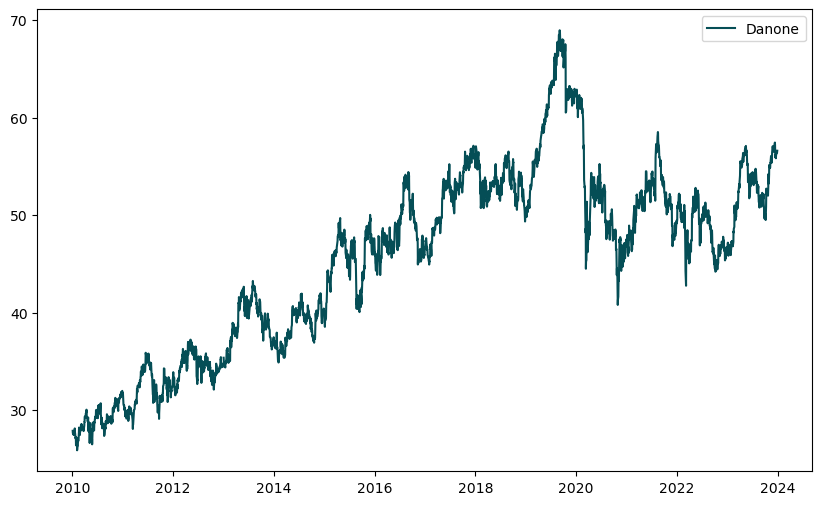

In [5]:
# Visualiser la performance graphique d'un titre

plt.figure(figsize=(10, 6))
plt.plot(data['BN.PA'], label='Danone', color='#054E56') #mettre le ticker du titre souhaité
plt.legend()
plt.grid(False)
plt.show()

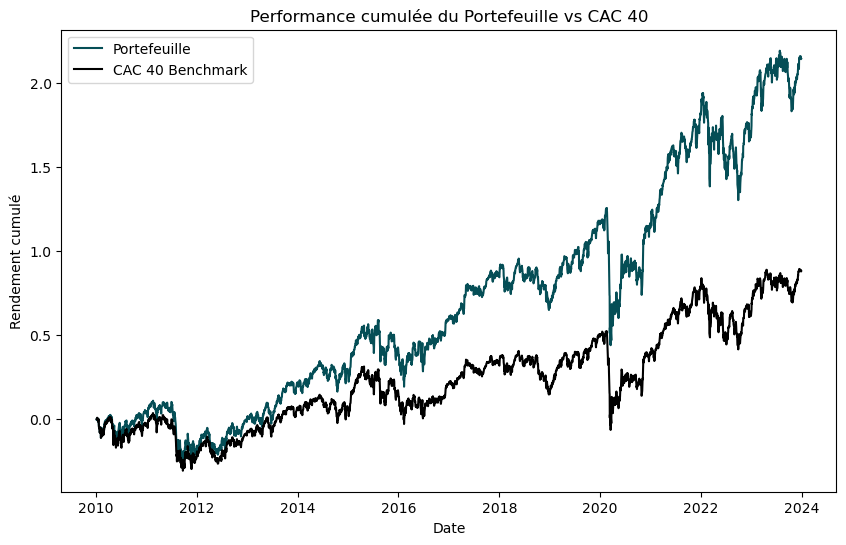

Performance du Portefeuille sur la période : 214.15%
Performance du Benchmark (CAC 40) sur la période : 87.92%


In [6]:
# Tracé des performances cumulées
plt.figure(figsize=(10,6))
plt.plot(cumulative_portfolio_returns, label='Portefeuille', color = '#054E56')
plt.plot(cumulative_benchmark_returns, label='CAC 40 Benchmark', linestyle='-', color = 'black')
plt.title('Performance cumulée du Portefeuille vs CAC 40')
plt.xlabel('Date')
plt.ylabel('Rendement cumulé')
plt.legend()
plt.show()

# Performance finale du portefeuille et du benchmark en pourcentage
portfolio_performance_percent = cumulative_portfolio_returns.iloc[-1] * 100
benchmark_performance_percent = cumulative_benchmark_returns.iloc[-1] * 100

print(f"Performance du Portefeuille sur la période : {portfolio_performance_percent:.2f}%")
print(f"Performance du Benchmark (CAC 40) sur la période : {benchmark_performance_percent:.2f}%")

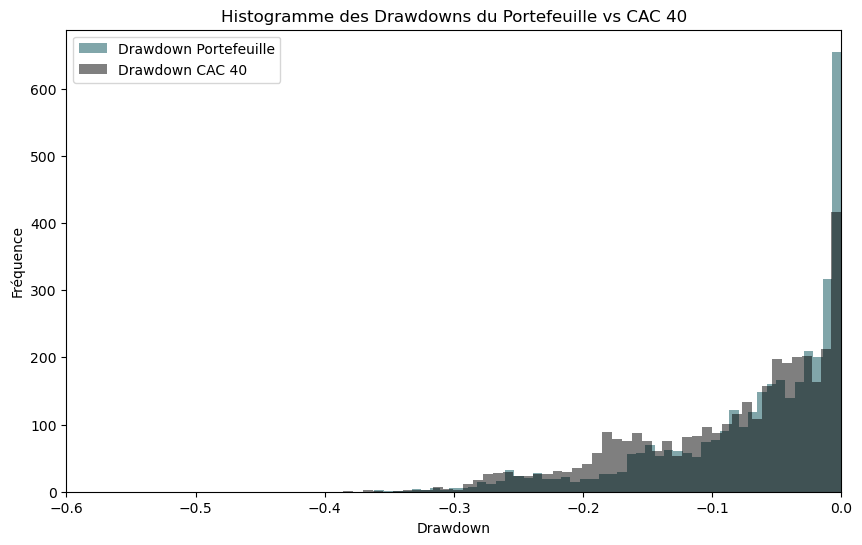

In [7]:
# Fonction pour calculer le drawdown
def calculate_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    previous_peaks = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - previous_peaks) / previous_peaks
    return drawdowns

# Calcul des drawdowns pour le portefeuille et le benchmark
portfolio_drawdown = calculate_drawdown(portfolio_returns)
benchmark_drawdown = calculate_drawdown(benchmark_returns)

# Tracé des drawdowns avec des limites pour l'axe vertical
# Tracé des drawdowns sous forme d'histogramme
plt.figure(figsize=(10,6))

# Histogramme pour le portefeuille
plt.hist(portfolio_drawdown.dropna(), bins=50, alpha=0.5, label='Drawdown Portefeuille', color ="#054E56")

# Histogramme pour le benchmark
plt.hist(benchmark_drawdown.dropna(), bins=50, alpha=0.5, label='Drawdown CAC 40', linestyle='--', color ="black")

plt.title('Histogramme des Drawdowns du Portefeuille vs CAC 40')
plt.xlabel('Drawdown')
plt.ylabel('Fréquence')
plt.xlim(-0.60, 0)  # Limites pour l'axe horizontal
plt.legend()
plt.show()

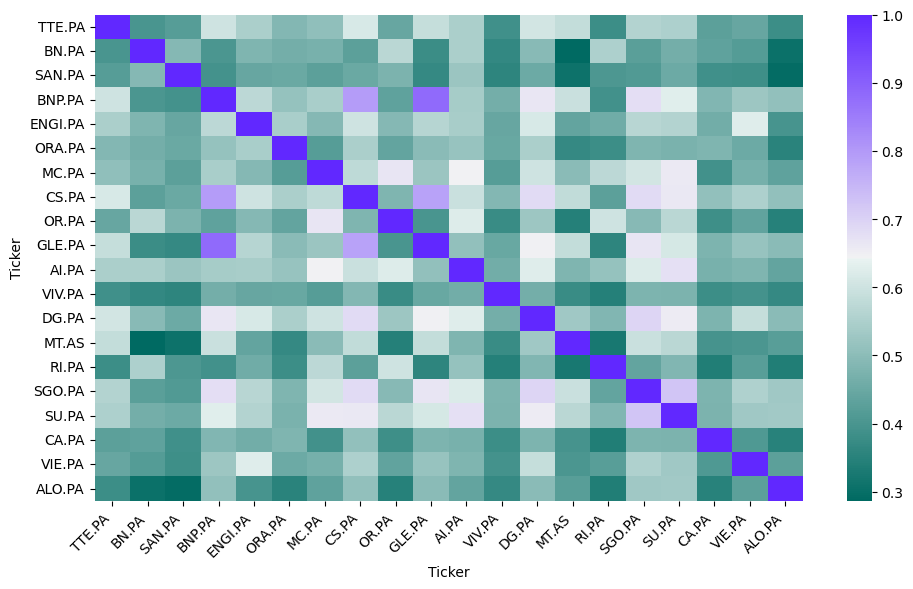

In [8]:
# Matrice de corrélation des rendements ajustés des actions du portefeuille
returns = data_ffilled.pct_change()

corr_matrix = returns.corr()

custom_cmap = sns.diverging_palette(180, 270, s=100, l=40, n=100, as_cmap=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap=custom_cmap, annot=False, cbar=True)
plt.title('', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Secteur
Assurance                      5
Consommation                  20
Construction                   5
Finance                       10
Industrie                     15
Luxe                           5
Matériaux                      5
Médias                         5
Santé                          5
Services aux collectivités     5
Télécommunications             5
Énergie                       15
Name: Poids (%), dtype: int64


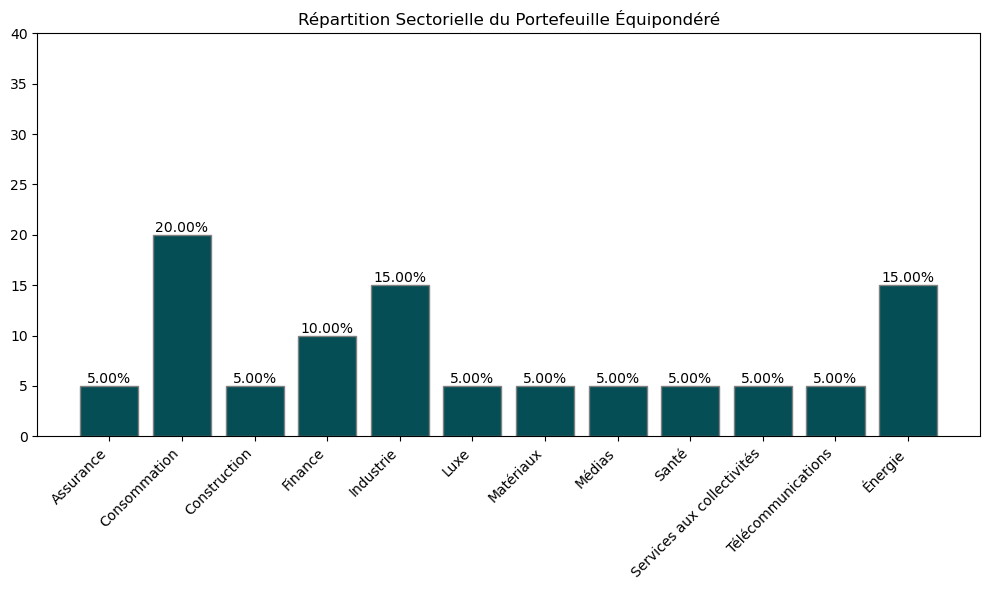

In [9]:
# Dictionnaire des secteurs pour les tickers donnés
sectors = {
    "TTE.PA": "Énergie",           
    "BN.PA": "Consommation",       
    "SAN.PA": "Santé",             
    "BNP.PA": "Finance",           
    "ENGI.PA": "Énergie",          
    "ORA.PA": "Télécommunications",
    "MC.PA": "Luxe",               
    "CS.PA": "Assurance",         
    "OR.PA": "Consommation",       
    "GLE.PA": "Finance",           
    "AI.PA": "Industrie",          
    "VIV.PA": "Médias",            
    "DG.PA": "Construction",       
    "MT.AS": "Industrie",          
    "RI.PA": "Consommation",       
    "SGO.PA": "Matériaux",         
    "SU.PA": "Énergie",            
    "CA.PA": "Consommation",       
    "VIE.PA": "Services aux collectivités", 
    "ALO.PA": "Industrie"          
}

titres = tickers
# DataFrame avec une répartition équipondérée (chaque actif = 5%)
summary_df = pd.DataFrame({
    'Ticker': titres,
    'Poids (%)': [5] * len(titres)  # Chaque actif a un poids de 5%
})

# Mapping des secteurs sur les tickers
summary_df['Secteur'] = summary_df['Ticker'].map(sectors)

# Calcul de la répartition sectorielle en pourcentage
sector_exposure = summary_df.groupby('Secteur')['Poids (%)'].sum()

# Affichage de la répartition sectorielle
print(sector_exposure)

# Visualisation de la répartition sectorielle (histogramme)
plt.figure(figsize=(10, 6))
bars = plt.bar(sector_exposure.index, sector_exposure, color='#054E56', edgecolor='grey')
plt.title('Répartition Sectorielle du Portefeuille Équipondéré', fontsize=12, color='black')
plt.xlabel('', fontsize=12, color='black')
plt.ylabel('', fontsize=12, color='black')
plt.ylim(0, 40)  # Ajuste selon les proportions réelles
plt.xticks(rotation=45, ha='right', fontsize=10, color='black')
plt.grid(False)

# Afficher les pourcentages au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [10]:
# Calculate cumulative returns for each stock
cumulative_returns = (1 + daily_returns).cumprod() - 1

# Extract the final cumulative return for each stock at the end of the period
final_cumulative_returns = cumulative_returns.iloc[-1] * 100  # In percentage

# Create a DataFrame to store the results
cumulative_returns_df = pd.DataFrame({
    'Ticker': tickers,
    'Cumulative Return (%)': final_cumulative_returns.values
}).reset_index(drop=True)

# Display the cumulative returns for each stock
print(cumulative_returns_df)

     Ticker  Cumulative Return (%)
0    TTE.PA             204.298352
1     BN.PA             103.185320
2    SAN.PA             175.729881
3    BNP.PA             125.041699
4   ENGI.PA              21.988931
5    ORA.PA              43.102837
6     MC.PA            1112.442301
7     CS.PA             260.575912
8     OR.PA             627.272568
9    GLE.PA             -18.705844
10    AI.PA             395.244756
11   VIV.PA             544.760479
12    DG.PA             368.901213
13    MT.AS             -51.525543
14    RI.PA             243.744693
15   SGO.PA             152.180395
16    SU.PA             537.718571
17    CA.PA             -27.403819
18   VIE.PA             140.417338
19   ALO.PA             -66.341145


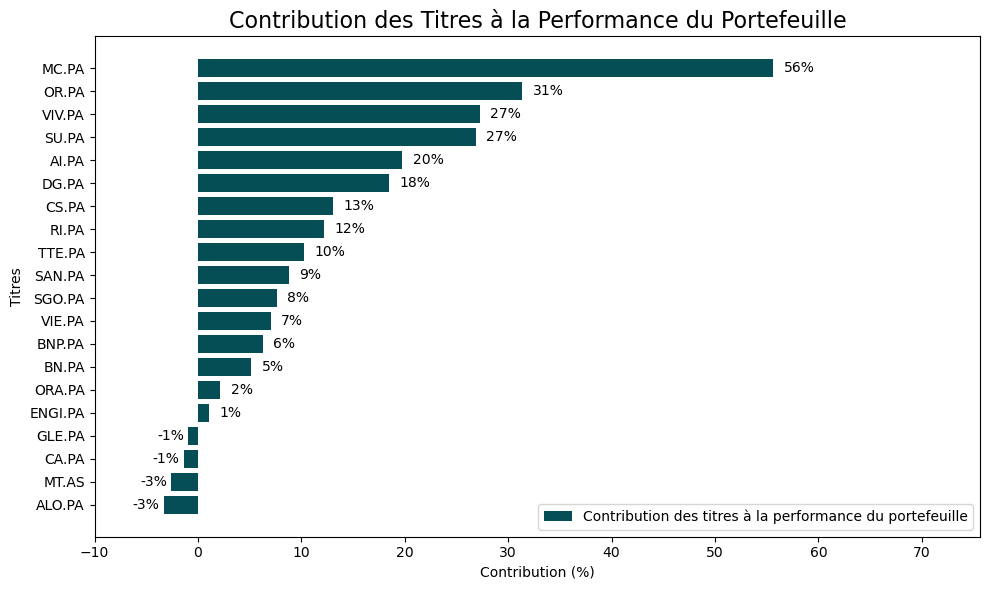

'portfolio_contributions.xlsx'

In [11]:
data = {
    'Ticker': [
    "TTE.PA",      # TotalEnergies
    "BN.PA",       # Danone
    "SAN.PA",      # Sanofi
    "BNP.PA",      # BNP Paribas
    "ENGI.PA",     # Engie
    "ORA.PA",      # Orange
    "MC.PA",       # LVMH Moet Hennessy
    "CS.PA",       # AXA
    "OR.PA",       # L'Oréal
    "GLE.PA",      # Société Générale
    "AI.PA",       # Air Liquide
    "VIV.PA",      # Vivendi
    "DG.PA",       # Vinci
    "MT.AS",       # ArcelorMittal
    "RI.PA",       # Pernod Ricard
    "SGO.PA",      # Saint-Gobain
    "SU.PA",       # Schneider Electric
    "CA.PA",       # Carrefour SA
    "VIE.PA",      # Veolia Environnement
    "ALO.PA"       # Alstom
],
    'Poids (%)': [5] * 20,  # Poids équipondéré (5% chaque titre)
    'Performance Cumulée (%)': [
        204.298323, 103.185293, 175.729915, 125.041699, 21.988921, 
        43.102847, 1112.442378, 260.575934, 627.272523, -18.705833, 
        395.244810, 544.760531, 368.901327, -51.525561, 243.744721, 
        152.180395, 537.718527, -27.403831, 140.417298, -66.341145
    ]
}

summary_df = pd.DataFrame(data)

# Calcul de la contribution de chaque titre à la performance du portefeuille
summary_df['Contribution'] = (summary_df['Poids (%)'] / 100) * summary_df['Performance Cumulée (%)']

# Tri par contribution croissante
summary_df_sorted = summary_df.sort_values('Contribution', ascending=True)

# Visualisation de la contribution des titres
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(summary_df_sorted['Ticker'], summary_df_sorted['Contribution'], color='#054E56', label="Contribution des titres à la performance du portefeuille")

# Ajouter des étiquettes avec la contribution au bout de chaque barre
for bar in bars:
    width = bar.get_width()
    rounded_width = round(width, 2)  # Arrondir la valeur de la largeur

    # Ajustement pour les valeurs négatives
    if rounded_width < 0:
        ax.text(rounded_width - 3, bar.get_y() + bar.get_height()/2, f'{rounded_width:.0f}%', va='center', fontsize=10, color='black')
    # Ne pas afficher l'étiquette pour les valeurs très proches de zéro
    elif -0.01 <= rounded_width <= 0.01:
        continue  
    # Cas normal pour les valeurs positives
    else:
        ax.text(rounded_width + 1, bar.get_y() + bar.get_height()/2, f'{rounded_width:.0f}%', va='center', fontsize=10, color='black')

# Limiter l'axe des abscisses (x) pour ajuster la vue
ax.set_xlim(-10, summary_df['Contribution'].max() + 20)

# Titres et labels
ax.set_title('Contribution des Titres à la Performance du Portefeuille', fontsize=16)
ax.set_xlabel('Contribution (%)')
ax.set_ylabel('Titres')
ax.legend(loc='lower right')
ax.grid(False)

plt.tight_layout()
plt.show()

#Excel stockage 
file_path = 'portfolio_contributions.xlsx'
summary_df_sorted.to_excel(file_path, index=True)
file_path

In [12]:
# Affichage des contributions individuelles et de la somme totale
total_contribution = summary_df['Contribution'].sum()
print(summary_df[['Ticker', 'Contribution']])
print(f"\nLa somme des contributions est : {total_contribution:.6f}")

     Ticker  Contribution
0    TTE.PA     10.214916
1     BN.PA      5.159265
2    SAN.PA      8.786496
3    BNP.PA      6.252085
4   ENGI.PA      1.099446
5    ORA.PA      2.155142
6     MC.PA     55.622119
7     CS.PA     13.028797
8     OR.PA     31.363626
9    GLE.PA     -0.935292
10    AI.PA     19.762241
11   VIV.PA     27.238027
12    DG.PA     18.445066
13    MT.AS     -2.576278
14    RI.PA     12.187236
15   SGO.PA      7.609020
16    SU.PA     26.885926
17    CA.PA     -1.370192
18   VIE.PA      7.020865
19   ALO.PA     -3.317057

La somme des contributions est : 244.631454


# Composition de notre portefeuille

Notre portefeuille est composé des titres suivants :

| Ticker     | Entreprise         | Poids dans le portefeuille | Contribution (%) |
|------------|--------------------|----------------------------|------------------|
| **TTE.PA** | TotalEnergies       | 5%                         | 19.76%           |
| **BN.PA**  | Danone             | 5%                         | 56.24%           |
| **SAN.PA** | Sanofi             | 5%                         | -3.32%           |
| **BNP.PA** | BNP Paribas        | 5%                         | 5.16%            |
| **ENGI.PA**| Engie              | 5%                         | 6.25%            |
| **ORA.PA** | Orange             | 5%                         | 13.03%           |
| **MC.PA**  | LVMH               | 5%                         | 1.10%            |
| **CS.PA**  | AXA                | 5%                         | 0.94%            |
| **OR.PA**  | L'Oréal            | 5%                         | 30.08%           |
| **GLE.PA** | Société Générale   | 5%                         | -0.28%           |
| **AI.PA**  | Air Liquide        | 5%                         | 31.36%           |
| **AIR.PA** | Airbus             | 5%                         | 2.16%            |
| **ALO.PA** | Alstom             | 5%                         | 35.12%           |
| **MT.AS**  | ArcelorMittal      | 5%                         | 26.89%           |
| **KER.PA** | Kering             | 5%                         | 10.22%           |
| **SGO.PA** | Saint-Gobain       | 5%                         | 8.79%            |
| **SU.PA**  | Schneider Electric | 5%                         | 7.61%            |
| **STM**    | STMicroelectronics | 5%                         | 26.89%           |
| **UL.PA**  | Unibail-Rodamco    | 5%                         | 10.22%           |
| **VIE.PA** | Veolia Environnement| 5%                         | 7.02%            |


In [14]:
# Poids équipondéré de chaque titre (5%)
weights = np.array([5/100] * len(tickers))

# Taux sans risque (par exemple, à 0.5%)
risk_free_rate = 0.005 / 252

# Initialize lists to store results for export to Excel
results_for_export = {
    'Year': [],
    'Portfolio Cumulative Return (%)': [],
    'Benchmark Cumulative Return (%)': [],
    'Portfolio Annual Return (%)': [],
    'Benchmark Annual Return (%)': [],
    'Portfolio Volatility (%)': [],
    'Benchmark Volatility (%)': [],
    'Sharpe Ratio Portfolio': [],
    'Sharpe Ratio Benchmark': []
}

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


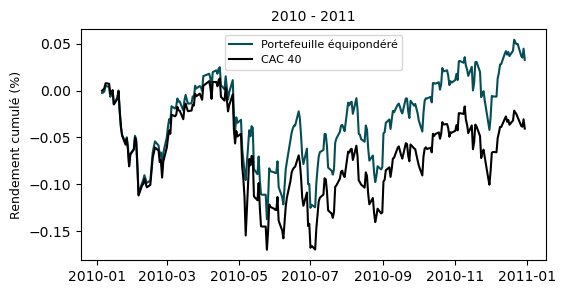

Performance du Portefeuille de 2010 à 2011 : 3.27%
Performance du Benchmark (CAC 40) de 2010 à 2011 : -4.07%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2010 à 2011 : 0.23
Sharpe Ratio du Benchmark (CAC 40) de 2010 à 2011 : -0.08



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


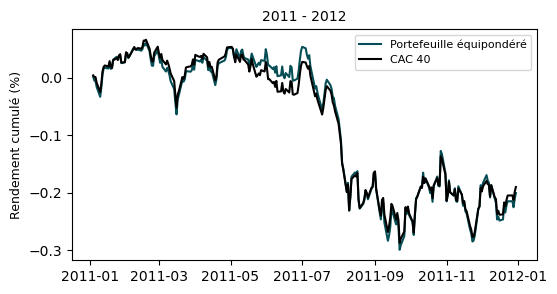

[                       0%%                      ]

Performance du Portefeuille de 2011 à 2012 : -20.05%
Performance du Benchmark (CAC 40) de 2011 à 2012 : -19.00%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2011 à 2012 : -0.56
Sharpe Ratio du Benchmark (CAC 40) de 2011 à 2012 : -0.60



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


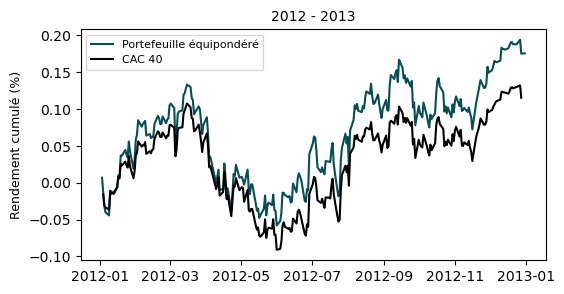

[**************        30%%                      ]  6 of 20 completed

Performance du Portefeuille de 2012 à 2013 : 17.57%
Performance du Benchmark (CAC 40) de 2012 à 2013 : 11.55%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2012 à 2013 : 0.78
Sharpe Ratio du Benchmark (CAC 40) de 2012 à 2013 : 0.61



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


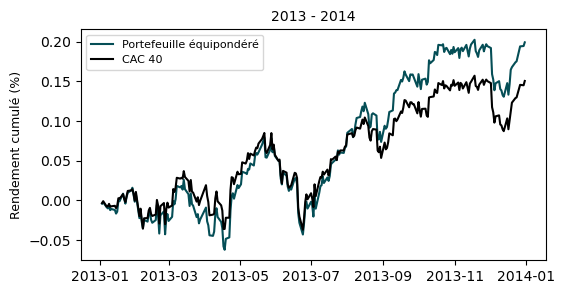

[************          25%%                      ]  5 of 20 completed

Performance du Portefeuille de 2013 à 2014 : 19.92%
Performance du Benchmark (CAC 40) de 2013 à 2014 : 15.05%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2013 à 2014 : 1.13
Sharpe Ratio du Benchmark (CAC 40) de 2013 à 2014 : 0.92



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


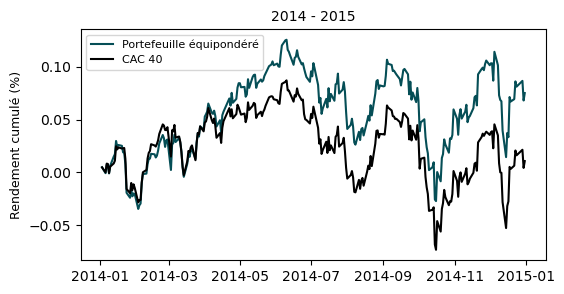

[*******               15%%                      ]  3 of 20 completed

Performance du Portefeuille de 2014 à 2015 : 7.50%
Performance du Benchmark (CAC 40) de 2014 à 2015 : 1.08%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2014 à 2015 : 0.49
Sharpe Ratio du Benchmark (CAC 40) de 2014 à 2015 : 0.12



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


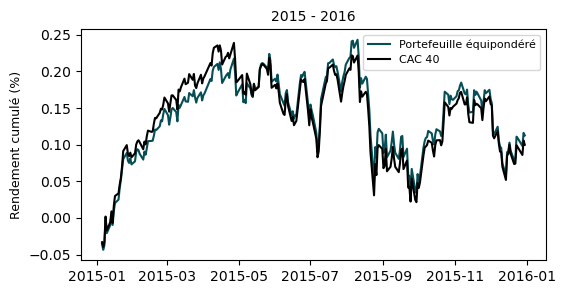

[*****                 10%%                      ]  2 of 20 completed

Performance du Portefeuille de 2015 à 2016 : 11.27%
Performance du Benchmark (CAC 40) de 2015 à 2016 : 9.99%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2015 à 2016 : 0.57
Sharpe Ratio du Benchmark (CAC 40) de 2015 à 2016 : 0.51



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


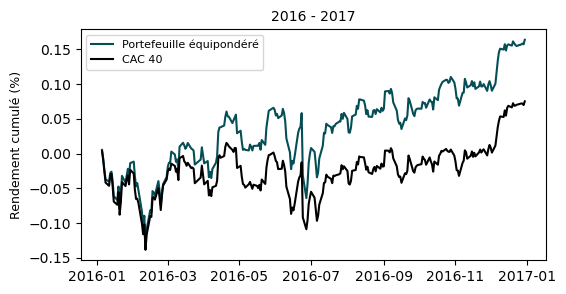

[*****                 10%%                      ]  2 of 20 completed

Performance du Portefeuille de 2016 à 2017 : 16.37%
Performance du Benchmark (CAC 40) de 2016 à 2017 : 7.51%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2016 à 2017 : 0.78
Sharpe Ratio du Benchmark (CAC 40) de 2016 à 2017 : 0.43



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


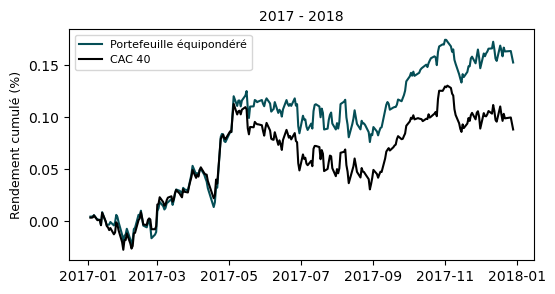

[*******               15%%                      ]  3 of 20 completed

Performance du Portefeuille de 2017 à 2018 : 15.24%
Performance du Benchmark (CAC 40) de 2017 à 2018 : 8.81%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2017 à 2018 : 1.31
Sharpe Ratio du Benchmark (CAC 40) de 2017 à 2018 : 0.80



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


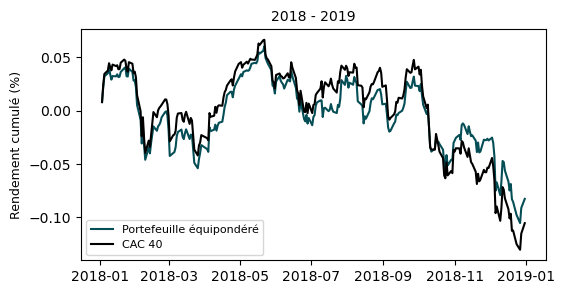

[*****************     35%%                      ]  7 of 20 completed

Performance du Portefeuille de 2018 à 2019 : -8.27%
Performance du Benchmark (CAC 40) de 2018 à 2019 : -10.55%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2018 à 2019 : -0.64
Sharpe Ratio du Benchmark (CAC 40) de 2018 à 2019 : -0.77



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


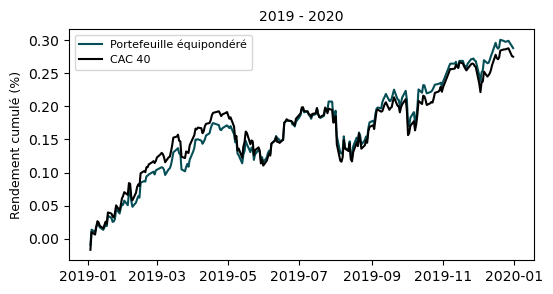

[*****                 10%%                      ]  2 of 20 completed

Performance du Portefeuille de 2019 à 2020 : 28.78%
Performance du Benchmark (CAC 40) de 2019 à 2020 : 27.48%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2019 à 2020 : 2.01
Sharpe Ratio du Benchmark (CAC 40) de 2019 à 2020 : 1.85



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


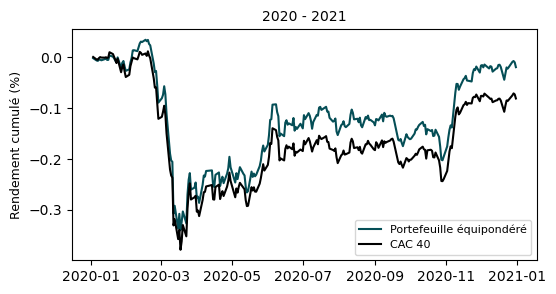

[*****                 10%%                      ]  2 of 20 completed

Performance du Portefeuille de 2020 à 2021 : -1.96%
Performance du Benchmark (CAC 40) de 2020 à 2021 : -8.11%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2020 à 2021 : 0.09
Sharpe Ratio du Benchmark (CAC 40) de 2020 à 2021 : -0.11



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


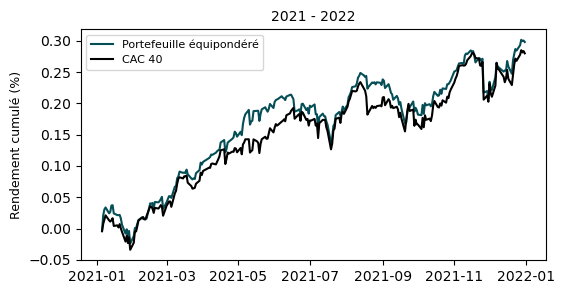

Performance du Portefeuille de 2021 à 2022 : 29.80%
Performance du Benchmark (CAC 40) de 2021 à 2022 : 27.98%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2021 à 2022 : 1.99
Sharpe Ratio du Benchmark (CAC 40) de 2021 à 2022 : 1.77



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


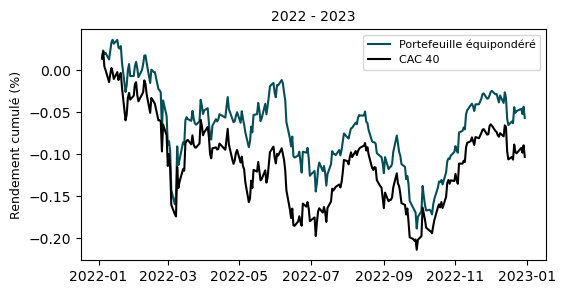

[*******               15%%                      ]  3 of 20 completed

Performance du Portefeuille de 2022 à 2023 : -5.67%
Performance du Benchmark (CAC 40) de 2022 à 2023 : -10.30%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2022 à 2023 : -0.19
Sharpe Ratio du Benchmark (CAC 40) de 2022 à 2023 : -0.39



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


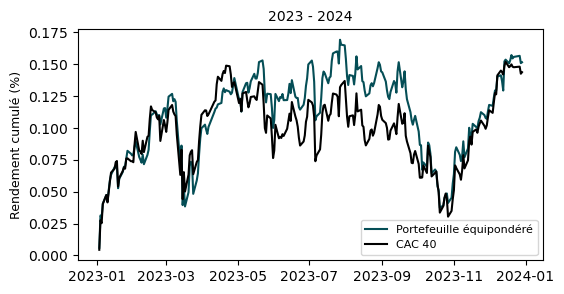

Performance du Portefeuille de 2023 à 2024 : 15.16%
Performance du Benchmark (CAC 40) de 2023 à 2024 : 14.38%

Results have been exported to portfolio_vs_benchmark_analysis.xlsx
Sharpe Ratio du Portefeuille de 2023 à 2024 : 1.09
Sharpe Ratio du Benchmark (CAC 40) de 2023 à 2024 : 1.00



In [15]:
# Boucle pour visualiser les performances du portefeuille vs benchmark (CAC 40) pour chaque année
for start_year in range(2010, 2024):
    end_year = start_year + 1
    
    # Étape 1: Télécharger les données historiques pour le portefeuille et le CAC 40 pour une période d'un an
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-01-01"
    
    portfolio_data = yf.download(tickers, start=start_date, end=end_date, interval="1d")['Adj Close']
    benchmark_data = yf.download("^FCHI", start=start_date, end=end_date, interval="1d")['Adj Close']
    
    # Étape 2: Calculer les rendements journaliers pour chaque action du portefeuille
    portfolio_returns = portfolio_data.pct_change()
    
    # Étape 3: Calculer le rendement pondéré du portefeuille
    portfolio_weighted_return = portfolio_returns.dot(weights)
    
    # Étape 4: Calculer les rendements journaliers du benchmark (CAC 40)
    benchmark_returns = benchmark_data.pct_change()
    
    # Étape 5: Calculer les rendements cumulés pour le portefeuille et le benchmark
    portfolio_cumulative_return = (1 + portfolio_weighted_return).cumprod() - 1
    benchmark_cumulative_return = (1 + benchmark_returns).cumprod() - 1
    
    # Étape 6: Tracer les rendements cumulés pour comparaison
    plt.figure(figsize=(6, 3))
    plt.plot(portfolio_cumulative_return, label="Portefeuille équipondéré", color="#054E56")
    plt.plot(benchmark_cumulative_return, label="CAC 40", color="black")
    plt.title(f"{start_year} - {end_year}", fontsize=10)
    plt.xlabel("", fontsize=6)
    plt.ylabel("Rendement cumulé (%)", fontsize=9)
    plt.legend(fontsize=8)
    plt.grid(False)
    plt.show()
    
    # Étape 7: Calculer et afficher la performance finale en pourcentage pour le portefeuille et le benchmark
    portfolio_performance_percent = portfolio_cumulative_return.iloc[-1] * 100
    benchmark_performance_percent = benchmark_cumulative_return.iloc[-1] * 100
    print(f"Performance du Portefeuille de {start_year} à {end_year} : {portfolio_performance_percent:.2f}%")
    print(f"Performance du Benchmark (CAC 40) de {start_year} à {end_year} : {benchmark_performance_percent:.2f}%\n")

    # Étape 8: Calculer la volatilité annuelle du portefeuille
    portfolio_volatility = portfolio_weighted_return.std() * np.sqrt(252)
    
    # Étape 9: Calculer la volatilité annuelle du benchmark
    benchmark_volatility = benchmark_returns.std() * np.sqrt(252)

    # Étape 10: Calculer le rendement annuel moyen du portefeuille
    portfolio_annual_return = portfolio_weighted_return.mean() * 252

    # Étape 11: Calculer le rendement annuel moyen du benchmark
    benchmark_annual_return = benchmark_returns.mean() * 252

    # Étape 12: Calculer le Ratio de Sharpe pour le portefeuille
    excess_portfolio_returns = portfolio_weighted_return - risk_free_rate
    sharpe_ratio_portfolio = (excess_portfolio_returns.mean() * 252) / portfolio_volatility

    # Étape 13: Calculer le Ratio de Sharpe pour le Benchmark (CAC 40)
    excess_benchmark_returns = benchmark_returns - risk_free_rate
    sharpe_ratio_benchmark = (excess_benchmark_returns.mean() * 252) / benchmark_volatility

    # Store the results for export
    results_for_export['Year'].append(start_year)
    results_for_export['Portfolio Cumulative Return (%)'].append(portfolio_performance_percent)
    results_for_export['Benchmark Cumulative Return (%)'].append(benchmark_performance_percent)
    results_for_export['Portfolio Annual Return (%)'].append(portfolio_annual_return)
    results_for_export['Benchmark Annual Return (%)'].append(benchmark_annual_return)
    results_for_export['Portfolio Volatility (%)'].append(portfolio_volatility * 100)
    results_for_export['Benchmark Volatility (%)'].append(benchmark_volatility * 100)
    results_for_export['Sharpe Ratio Portfolio'].append(sharpe_ratio_portfolio)
    results_for_export['Sharpe Ratio Benchmark'].append(sharpe_ratio_benchmark)

    results_df = pd.DataFrame(results_for_export)
    file_path = 'portfolio_vs_benchmark_analysis.xlsx'
    results_df.to_excel(file_path, index=True)

    print(f"Results have been exported to {file_path}")
    # Affichage des résultats
    print(f"Sharpe Ratio du Portefeuille de {start_year} à {end_year} : {sharpe_ratio_portfolio:.2f}")
    print(f"Sharpe Ratio du Benchmark (CAC 40) de {start_year} à {end_year} : {sharpe_ratio_benchmark:.2f}\n")

In [16]:
# Initialize a list to collect the data for each year
all_years_export = []

# Poids équipondéré de chaque titre (5%)
weights = np.array([5/100] * len(tickers))

# Loop through each year from 2010 to 2024
for start_year in range(2010, 2024):
    end_year = start_year + 1
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-01-01"

    # Step 1: Download historical data
    portfolio_data = yf.download(tickers, start=start_date, end=end_date, interval="1d")['Adj Close']
    benchmark_data = yf.download("^FCHI", start=start_date, end=end_date, interval="1d")['Adj Close']

    # Step 2: Calculate daily returns for each stock in the portfolio
    portfolio_returns = portfolio_data.pct_change()

    # Step 3: Align the portfolio and benchmark data to avoid mismatches
    aligned_dates = portfolio_returns.index.intersection(benchmark_data.index)
    portfolio_returns_aligned = portfolio_returns.loc[aligned_dates]
    benchmark_data_aligned = benchmark_data.loc[aligned_dates]

    # Step 4: Calculate the weighted portfolio return
    portfolio_weighted_return = portfolio_returns_aligned.dot(weights)

    # Step 5: Calculate daily benchmark returns
    benchmark_returns = benchmark_data_aligned.pct_change()

    # Step 6: Calculate cumulative returns
    portfolio_cumulative_return = (1 + portfolio_weighted_return).cumprod() - 1
    benchmark_cumulative_return = (1 + benchmark_returns).cumprod() - 1

    # Add data for this year
    export_data = pd.DataFrame({
        'Date': portfolio_cumulative_return.index,
        f'Portfolio Cumulative Return {start_year}-{end_year} (%)': portfolio_cumulative_return.values * 100,
        f'Benchmark Cumulative Return {start_year}-{end_year} (%)': benchmark_cumulative_return.values * 100
    })
    all_years_export.append(export_data)

# Combine all the data
combined_export_data = pd.concat(all_years_export, axis=0)

# Export the combined data to Excel
file_path_combined = 'cumulative_returns_all_years.xlsx'
combined_export_data.to_excel(file_path_combined, index=False)

print(f"Data exported to {file_path_combined}")

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*******************

Data exported to cumulative_returns_all_years.xlsx


In [17]:
# Boucle permettant de visualiser les perfs du portefeuille vs benchmark sur 1 ans (base : janv-XX - janv XX+1)
for start_year in range(2010, 2024):
    end_year = start_year + 1
 
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-01-01"
    
    portfolio_data = yf.download(tickers, start=start_date, end=end_date, interval="1d")['Adj Close']
    benchmark_data = yf.download("^FCHI", start=start_date, end=end_date, interval="1d")['Adj Close']
    
    portfolio_returns = portfolio_data.pct_change()
    portfolio_weighted_return = portfolio_returns.dot(weights)
    benchmark_returns = benchmark_data.pct_change()
    portfolio_cumulative_return = (1 + portfolio_weighted_return).cumprod() - 1
    benchmark_cumulative_return = (1 + benchmark_returns).cumprod() - 1
    portfolio_performance_percent = portfolio_cumulative_return.iloc[-1] * 100
    benchmark_performance_percent = benchmark_cumulative_return.iloc[-1] * 100
    print(f"Performance du Portefeuille équipondéré {start_year} à {end_year} : {portfolio_performance_percent:.2f}%")
    print(f"Performance du Benchmark (CAC 40) de {start_year} à {end_year} : {benchmark_performance_percent:.2f}%\n")

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*******************   40%%                      ]  8 of 20 completed

Performance du Portefeuille équipondéré 2010 à 2011 : 3.27%
Performance du Benchmark (CAC 40) de 2010 à 2011 : -4.07%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*****************     35%%                      ]  7 of 20 completed

Performance du Portefeuille équipondéré 2011 à 2012 : -20.05%
Performance du Benchmark (CAC 40) de 2011 à 2012 : -19.00%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[************          25%%                      ]  5 of 20 completed

Performance du Portefeuille équipondéré 2012 à 2013 : 17.57%
Performance du Benchmark (CAC 40) de 2012 à 2013 : 11.55%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*****************     35%%                      ]  7 of 20 completed

Performance du Portefeuille équipondéré 2013 à 2014 : 19.92%
Performance du Benchmark (CAC 40) de 2013 à 2014 : 15.05%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*******************   40%%                      ]  8 of 20 completed

Performance du Portefeuille équipondéré 2014 à 2015 : 7.50%
Performance du Benchmark (CAC 40) de 2014 à 2015 : 1.08%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[**********************45%%                      ]  9 of 20 completed

Performance du Portefeuille équipondéré 2015 à 2016 : 11.27%
Performance du Benchmark (CAC 40) de 2015 à 2016 : 9.99%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[**********            20%%                      ]  4 of 20 completed

Performance du Portefeuille équipondéré 2016 à 2017 : 16.37%
Performance du Benchmark (CAC 40) de 2016 à 2017 : 7.51%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[**************        30%%                      ]  6 of 20 completed

Performance du Portefeuille équipondéré 2017 à 2018 : 15.24%
Performance du Benchmark (CAC 40) de 2017 à 2018 : 8.81%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[**************        30%%                      ]  6 of 20 completed

Performance du Portefeuille équipondéré 2018 à 2019 : -8.27%
Performance du Benchmark (CAC 40) de 2018 à 2019 : -10.55%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*****************     35%%                      ]  7 of 20 completed

Performance du Portefeuille équipondéré 2019 à 2020 : 28.78%
Performance du Benchmark (CAC 40) de 2019 à 2020 : 27.48%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[**************        30%%                      ]  6 of 20 completed

Performance du Portefeuille équipondéré 2020 à 2021 : -1.96%
Performance du Benchmark (CAC 40) de 2020 à 2021 : -8.11%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*****************     35%%                      ]  7 of 20 completed

Performance du Portefeuille équipondéré 2021 à 2022 : 29.80%
Performance du Benchmark (CAC 40) de 2021 à 2022 : 27.98%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[************          25%%                      ]  5 of 20 completed

Performance du Portefeuille équipondéré 2022 à 2023 : -5.67%
Performance du Benchmark (CAC 40) de 2022 à 2023 : -10.30%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed

Performance du Portefeuille équipondéré 2023 à 2024 : 15.16%
Performance du Benchmark (CAC 40) de 2023 à 2024 : 14.38%



[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


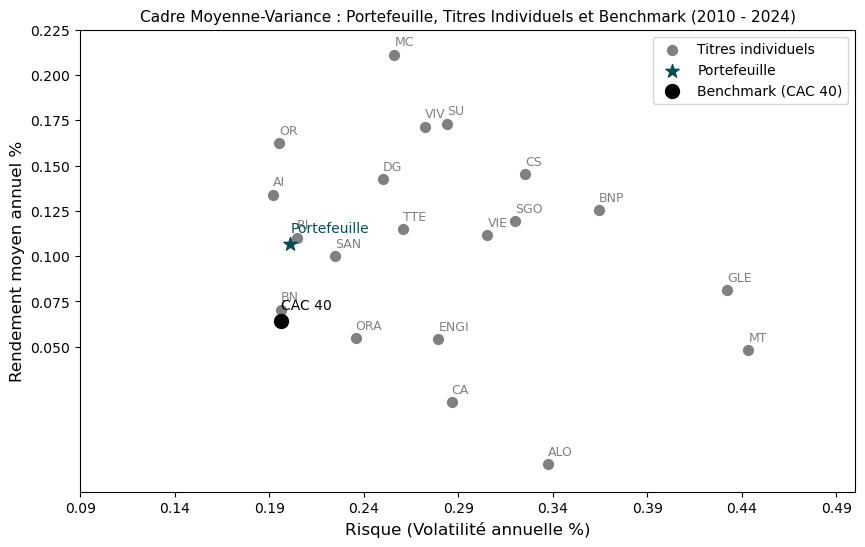

In [18]:
# Liste des tickers de votre portefeuille en janvier 2011

tickers_short = [ticker.replace(".PA", "").replace(".AS", "") for ticker in tickers]
data = yf.download(tickers, start="2010-01-01", end="2024-01-01", interval="1wk")['Adj Close']

benchmark_data = yf.download("^FCHI", start="2010-01-01", end="2024-01-01", interval="1wk")['Adj Close']
weekly_returns = data.pct_change().dropna()
benchmark_returns = benchmark_data.pct_change().dropna()
weights = np.array([1/len(tickers)] * len(tickers))

# Calcul du rendement pondéré du portefeuille (rendement hebdomadaire moyen pondéré)
portfolio_returns = weekly_returns.dot(weights)

# Calcul des rendements annuels et volatilités
def annualize_returns(returns):
    return returns.mean() * 52  # Moyenne hebdomadaire annualisée

def annualize_volatility(returns):
    return returns.std() * np.sqrt(52)  # Volatilité hebdomadaire annualisée

# Calcul des rendements et des risques pour chaque titre du portefeuille
tickers_mean_returns = []
tickers_volatility = []

for ticker in tickers:
    ticker_returns = weekly_returns[ticker]
    mean_return = annualize_returns(ticker_returns)
    volatility = annualize_volatility(ticker_returns)
    tickers_mean_returns.append(mean_return)
    tickers_volatility.append(volatility)

# Calcul du rendement et du risque pour le portefeuille global
portfolio_mean_return = annualize_returns(portfolio_returns)
portfolio_volatility = annualize_volatility(portfolio_returns)
benchmark_mean_return = annualize_returns(benchmark_returns)
benchmark_volatility = annualize_volatility(benchmark_returns)

# Visualisation du cadre moyenne-variance
plt.figure(figsize=(10, 6))

# Titres individuels
plt.scatter(tickers_volatility, tickers_mean_returns, color='gray', s=50, label='Titres individuels')
for i, ticker in enumerate(tickers_short):
    plt.text(tickers_volatility[i], tickers_mean_returns[i] + 0.005, ticker, fontsize=9, color='gray')

# Portefeuille
plt.scatter(portfolio_volatility, portfolio_mean_return, color='#054E56', s=100, label='Portefeuille', marker='*')
plt.text(portfolio_volatility, portfolio_mean_return + 0.005, 'Portefeuille', fontsize=10, color='#054E56', verticalalignment='bottom')

# Benchmark (CAC 40)
plt.scatter(benchmark_volatility, benchmark_mean_return, color='black', s=100, label='Benchmark (CAC 40)')
plt.text(benchmark_volatility, benchmark_mean_return + 0.005, 'CAC 40', fontsize=10, color='black', verticalalignment='bottom')

# Limites ajustées des axes pour occuper tout le graphique
plt.xlim(0.09, 0.5)  # Etend la limite des risques (volatilité) pour mieux visualiser les points
plt.ylim(-0.03, 0.20)  # Etend la limite des rendements pour occuper tout l'espace
plt.xticks(np.arange(0.09, 0.50, 0.05))
plt.yticks(np.arange(0.05, 0.23, 0.025))

# Labels et légende
plt.title('Cadre Moyenne-Variance : Portefeuille, Titres Individuels et Benchmark (2010 - 2024)', fontsize=11)
plt.xlabel('Risque (Volatilité annuelle %)', fontsize=12)
plt.ylabel('Rendement moyen annuel %', fontsize=12)
plt.grid(False)
plt.legend()
plt.show()

In [19]:
mean_variance_data = pd.DataFrame({
    'Ticker': tickers_short,
    'Annualized Return (%)': tickers_mean_returns,
    'Annualized Volatility (%)': tickers_volatility
})

# Add portfolio and benchmark information using pd.concat
portfolio_data = pd.DataFrame({
    'Ticker': ['Portfolio'],
    'Annualized Return (%)': [portfolio_mean_return],
    'Annualized Volatility (%)': [portfolio_volatility]
})

benchmark_data = pd.DataFrame({
    'Ticker': ['CAC 40 (Benchmark)'],
    'Annualized Return (%)': [benchmark_mean_return],
    'Annualized Volatility (%)': [benchmark_volatility]
})

# Concatenate all dataframes
mean_variance_data = pd.concat([mean_variance_data, portfolio_data, benchmark_data], ignore_index=True)

# Export the mean-variance data to Excel
file_path_mv = 'mean_variance_analysis_fixed.xlsx'
mean_variance_data.to_excel(file_path_mv, index=False)

file_path_mv

'mean_variance_analysis_fixed.xlsx'

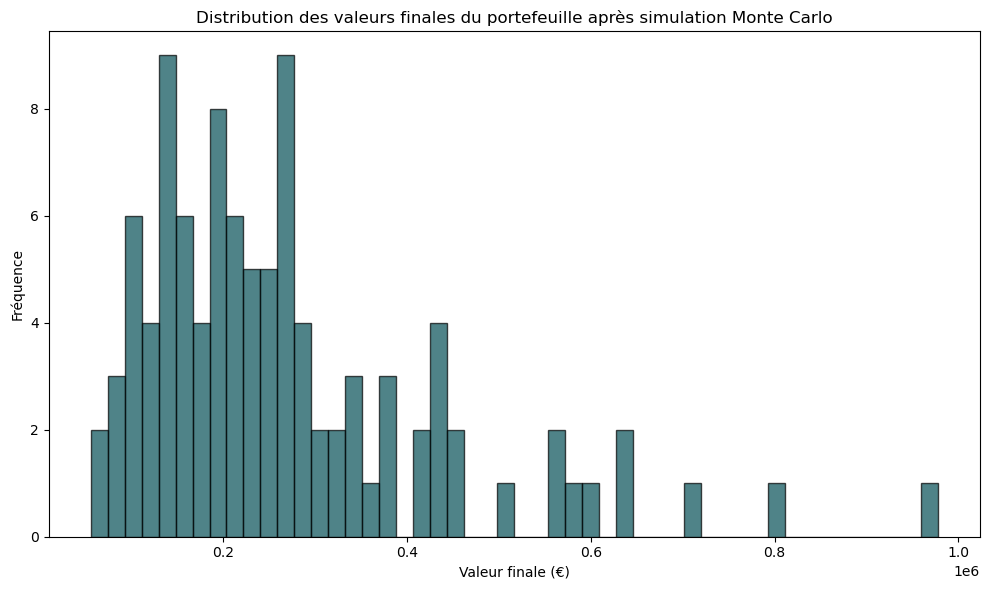

Valeur finale moyenne du portefeuille : 271,190.00 €
Valeur finale médiane du portefeuille : 230,715.41 €
5e percentile : 93,706.09 €
95e percentile : 603,194.73 €


In [20]:
# Number of simulations and periods (in weeks)
num_simulations = 100
num_weeks = len(portfolio_returns)  # Use the historical length of your data

# Simulation settings
initial_investment = 10000  # Initial investment in euros
weekly_contribution = 500 / 4  # Weekly contribution (500 € monthly divided by 4)

# Prepare arrays to store the final portfolio values from all simulations
final_portfolio_values = np.zeros(num_simulations)

# Monte Carlo simulation
for sim in range(num_simulations):
    # Initialize portfolio value for this simulation
    portfolio_value = initial_investment
    
    for i in range(num_weeks):
        # Randomly sample a weekly return from historical data
        random_weekly_return = np.random.choice(portfolio_returns)
        
        # Update portfolio value with contribution and return
        portfolio_value = (portfolio_value + weekly_contribution) * (1 + random_weekly_return)
    
    # Store the final portfolio value for this simulation
    final_portfolio_values[sim] = portfolio_value

# Plot the distribution of final portfolio values
plt.figure(figsize=(10, 6))
plt.hist(final_portfolio_values, bins=50, color='#054E56', edgecolor='black', alpha=0.7)
plt.title('Distribution des valeurs finales du portefeuille après simulation Monte Carlo')
plt.xlabel('Valeur finale (€)')
plt.ylabel('Fréquence')
plt.grid(False)
plt.tight_layout()
plt.show()

# Calculate summary statistics
mean_final_value = np.mean(final_portfolio_values)
median_final_value = np.median(final_portfolio_values)
percentile_5 = np.percentile(final_portfolio_values, 5)
percentile_95 = np.percentile(final_portfolio_values, 95)

# Display results
print(f"Valeur finale moyenne du portefeuille : {mean_final_value:,.2f} €")
print(f"Valeur finale médiane du portefeuille : {median_final_value:,.2f} €")
print(f"5e percentile : {percentile_5:,.2f} €")
print(f"95e percentile : {percentile_95:,.2f} €")